# Data Analysis and Preparation

In [1]:
# !pip install torch

In [2]:
# !pip install PyQtChart

In [3]:
# !pip install PyQtWebEngine

In [4]:
# from IPython.display import Image, display

# image_path = 'figs/swing-phases.png'
# display(Image(filename=image_path))


In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def load_data_from_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def create_trajectory_plot(data, start_frame=None, end_frame=None):
    all_predictions = []
    for frame_num, frame_data in enumerate(data):
        if (start_frame is None or frame_num >= start_frame) and (end_frame is None or frame_num <= end_frame):
            for pred in frame_data.get('predictions', []):
                pred['frame'] = frame_num
                all_predictions.append(pred)
    
    df = pd.DataFrame(all_predictions)
    classes = df['class'].unique()
    
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=("X-coordinate Trajectory", "Y-coordinate Trajectory"))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_map = dict(zip(classes, colors[:len(classes)]))
    
    for cls in classes:
        class_data = df[df['class'] == cls].sort_values('frame')
        
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['x'], mode='lines+markers',
                       name=f'{cls} (x)', line=dict(color=color_map[cls])),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(x=class_data['frame'], y=class_data['y'], mode='lines+markers',
                       name=f'{cls} (y)', line=dict(color=color_map[cls], dash='dash')),
            row=2, col=1
        )
    
    fig.update_layout(height=800, title_text="Object Trajectories in Golf Swing Video")
    fig.update_xaxes(title_text="Frame Number")
    fig.update_yaxes(title_text="X Position", row=1, col=1)
    fig.update_yaxes(title_text="Y Position", row=2, col=1)
    
    return fig

def plot_evenly_distributed_frames(video_path, start_frame=None, end_frame=None, num_frames=9):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    start_frame = 0 if start_frame is None else start_frame
    end_frame = total_frames - 1 if end_frame is None else end_frame

    frame_positions = np.linspace(start_frame, end_frame, num_frames, dtype=int)
    cols = math.ceil(math.sqrt(num_frames))
    rows = math.ceil(num_frames / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, frame_position in enumerate(frame_positions):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Error: Could not read frame at position {frame_position}.")
            continue
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[i].imshow(frame)
        axes[i].set_title(f'Frame {frame_position}')
        axes[i].axis('off')
    
    for j in range(len(frame_positions), len(axes)):
        axes[j].axis('off')
    
    cap.release()
    plt.tight_layout(pad=2.0)
    return fig

def combined_plot(video_file, start_frame=None, end_frame=None, num_frames=9):
    # Construct file paths
    video_path = os.path.join('input_videos', video_file)
    jsonl_path = os.path.join('predictions', f"{os.path.splitext(video_file)[0]}_predictions.jsonl")

    # Load JSONL data
    data = load_data_from_jsonl(jsonl_path)

    # Create trajectory plot
    trajectory_fig = create_trajectory_plot(data, start_frame, end_frame)

    # Create distributed frames plot
    frames_fig = plot_evenly_distributed_frames(video_path, start_frame, end_frame, num_frames)

    # Display plots
    trajectory_fig.show()
    plt.figure(frames_fig.number)
    plt.show()


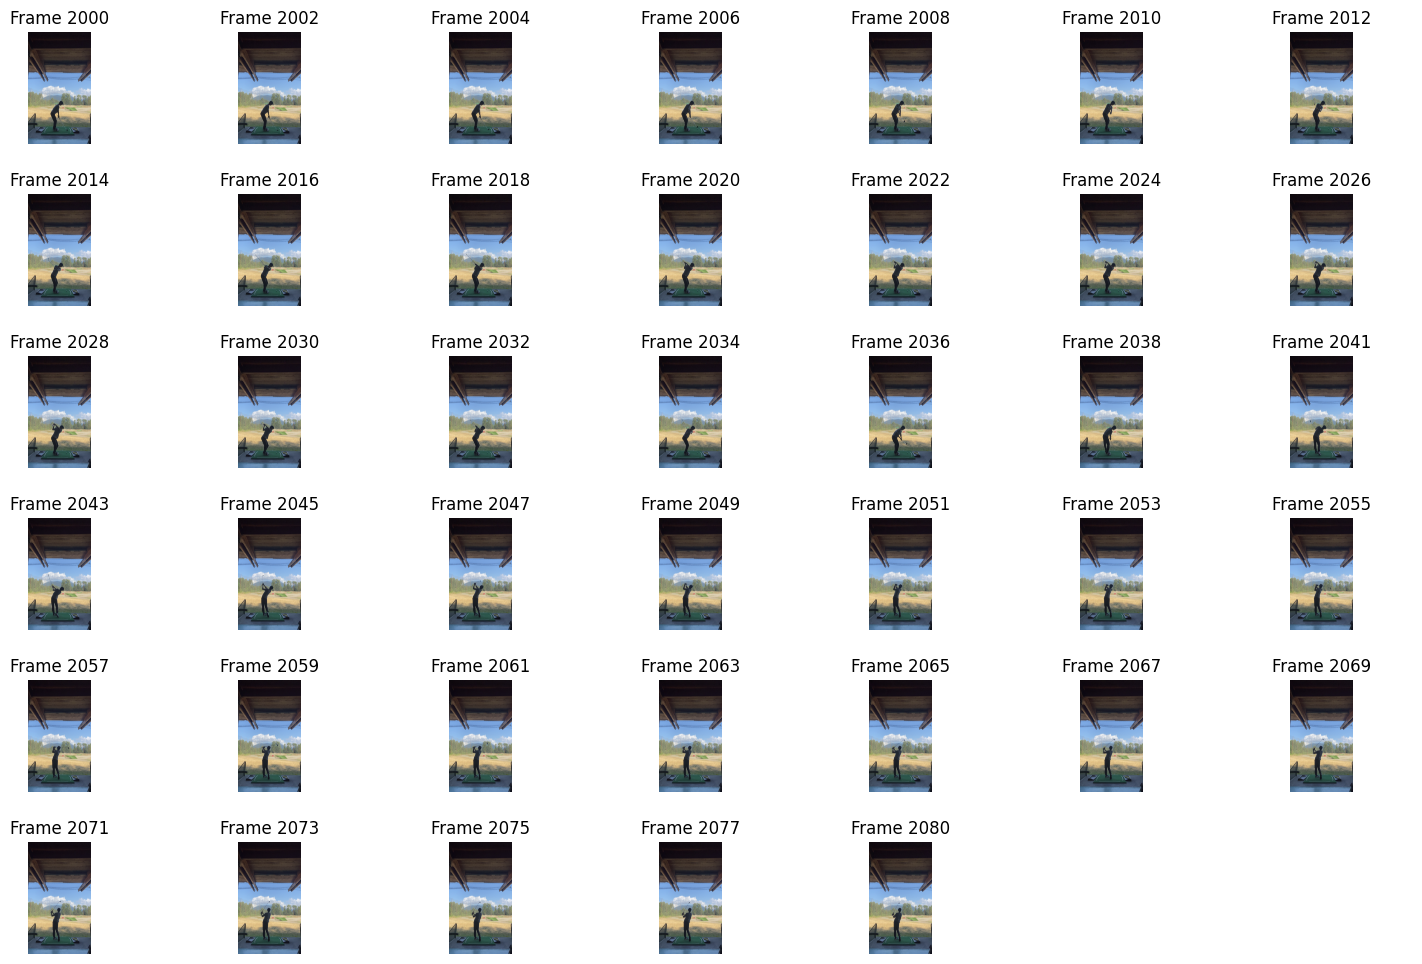

In [54]:
# Example usage
video_file = "03.MOV"  # or "03.mp4" if it's an mp4 file
start_frame = 2000
end_frame = 2080
num_frames = 40

combined_plot(video_file, start_frame, end_frame, num_frames)

In [67]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from ipywidgets import interactive, IntSlider, Button, Output, VBox, HBox, Text, Layout
from IPython.display import display

def save_swing_intervals(swing_intervals, output_dir, video_file):
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{os.path.splitext(video_file)[0]}_swing_intervals.json")
    with open(output_file, 'w') as f:
        json.dump(swing_intervals, f)
    print(f"Swing intervals saved to {output_file}")

def find_swing_intervals(video_file):
    video_path = os.path.join('input_videos', video_file)
    jsonl_path = os.path.join('predictions', f"{os.path.splitext(video_file)[0]}_predictions.jsonl")

    data = load_data_from_jsonl(jsonl_path)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    swing_intervals = []
    current_interval = [None, None]

    trajectory_fig = create_trajectory_plot(data)
    trajectory_fig.update_layout(height=600)  # Make the plot taller

    image_output = Output()
    trajectory_output = Output()
    
    with trajectory_output:
        display(trajectory_fig)
    
    def update_plot(frame):
        with image_output:
            image_output.clear_output(wait=True)
            
            # Show current frame from video
            cap = cv2.VideoCapture(video_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
            ret, img = cap.read()
            cap.release()
            
            if ret:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(12, 8))  # Make the image larger
                plt.imshow(img)
                plt.title(f"Frame {frame}")
                plt.axis('off')
                plt.show()

    def mark_start(b):
        current_interval[0] = frame_slider.value
        print(f"Marked start of swing at frame {current_interval[0]}")

    def mark_end(b):
        current_interval[1] = frame_slider.value
        if current_interval[0] is not None and current_interval[1] > current_interval[0]:
            swing_intervals.append(tuple(current_interval))
            print(f"Added swing interval: {current_interval}")
            current_interval[0] = None
            current_interval[1] = None
        else:
            print("Invalid interval. Make sure to mark start before end and end frame is after start frame.")

    def show_intervals(b):
        print("Current swing intervals:")
        for interval in swing_intervals:
            print(interval)

    def check_intervals(b):
        valid = True
        for interval in swing_intervals:
            start, end = interval
            if not (end > start and (end - start) <= 80):
                valid = False
                print(f"Invalid interval: {interval}")
        if valid:
            print("All intervals are valid.")

    def set_frame(b):
        try:
            frame = int(frame_input.value)
            if 0 <= frame < total_frames:
                frame_slider.value = frame
            else:
                print(f"Frame number must be between 0 and {total_frames - 1}")
        except ValueError:
            print("Please enter a valid integer for the frame number")

    def increment_frame(b):
        if frame_slider.value < total_frames - 1:
            frame_slider.value += 1

    def decrement_frame(b):
        if frame_slider.value > 0:
            frame_slider.value -= 1

    def save_intervals(b):
        save_swing_intervals(swing_intervals, 'swing_intervals', video_file)

    frame_slider = IntSlider(min=0, max=total_frames-1, step=1, description='Frame:', layout=Layout(width='800px'))
    frame_input = Text(description='Go to frame:')
    set_frame_button = Button(description="Set Frame")
    increment_frame_button = Button(description="Next Frame")
    decrement_frame_button = Button(description="Previous Frame")
    start_button = Button(description="Mark Start")
    end_button = Button(description="Mark End")
    show_button = Button(description="Show Intervals")
    save_button = Button(description="Save Intervals")
    check_button = Button(description="Check Intervals")

    start_button.on_click(mark_start)
    end_button.on_click(mark_end)
    show_button.on_click(show_intervals)
    set_frame_button.on_click(set_frame)
    increment_frame_button.on_click(increment_frame)
    decrement_frame_button.on_click(decrement_frame)
    save_button.on_click(save_intervals)
    check_button.on_click(check_intervals)

    interactive_plot = interactive(update_plot, frame=frame_slider)
    
    display(VBox([
        trajectory_output,
        interactive_plot,
        image_output,
        HBox([frame_input, set_frame_button]),
        HBox([decrement_frame_button, increment_frame_button]),
        HBox([start_button, end_button, show_button, check_button, save_button])
    ]))

    return swing_intervals

# Usage
# video_file = "your_video_file.mp4"
# swing_intervals = find_swing_intervals(video_file)

In [70]:
video_file = "IMG_3518.MOV"
swing_intervals = find_swing_intervals(video_file)

Marked start of swing at frame 3095


Added swing interval: [3095, 3163]


Marked start of swing at frame 3844


Added swing interval: [3844, 3905]


Marked start of swing at frame 4410


Added swing interval: [4410, 4463]


Marked start of swing at frame 5008


Added swing interval: [5008, 5060]


Marked start of swing at frame 5494


Added swing interval: [5494, 5548]


Marked start of swing at frame 6280


Added swing interval: [6280, 6330]


Marked start of swing at frame 7100


Added swing interval: [7100, 7152]


Marked start of swing at frame 7960


Added swing interval: [7960, 8010]


Marked start of swing at frame 8625


Added swing interval: [8625, 8677]


Marked start of swing at frame 9177


Added swing interval: [9177, 9226]
Current swing intervals:
(3095, 3163)
(3844, 3905)
(4410, 4463)
(5008, 5060)
(5494, 5548)
(6280, 6330)
(7100, 7152)
(7960, 8010)
(8625, 8677)
(9177, 9226)
All intervals are valid.
Swing intervals saved to swing_intervals\IMG_3518_swing_intervals.json


In [62]:
swing_intervals

[(596, 644), (1353, 1400)]

Previously, I have created `scripts/roboflow_pipeline` to obtain predictions as a jsonl file. Now I need to preprocess trajectory data into fixed-length sequences and labeling them as golf swings or not